# 第4章 朴素贝叶斯法

基于贝叶斯定理：

$$
P(Y|X) = \frac{P(Y)P(X|Y)}{P(X)}
$$

与特征条件独立假设，意味着向量 $X$ 中各个特征的联合概率等于各特征概率相乘

$$
\begin{equation}
\begin{aligned}
P(X=x|Y=c_k) &= P(X^{(1)}=x^{(1)}, \ldots ,X^{(n)}=x^{(n)}|Y=c_k)\\
&=\prod_{j=1}^{n}P(X^{(j)}=x^{(j)}|Y=c_k)
\end{aligned}
\end{equation}
$$

正是因为对条件概率分布作了条件独立性的假设，才得名为朴素贝叶斯法

这是一个较强的假设，使得朴素贝叶斯法变得简单，但有时会牺牲一定的分类准确率

## 朴素贝叶斯分类器

根据贝叶斯定理与特征独立假设，有

$$
P(Y=c_{k}|X=x) = \frac{P(Y=c_{k})P(X=x|Y=c_{k})}{\sum_{k}P(Y=c_{k})P(X=x|Y=c_{k})}
$$

所以朴素贝叶斯分类器选择*后验概率最大*的类别 $c_{k}$，有

$$
\begin{align}
y = f(x) &= \arg \max_{c_{k}} \frac{P(Y=c_{k})P(X=x|Y=c_{k})}{\sum_{k}P(Y=c_{k})P(X=x|Y=c_{k})}\\
&= \arg \max_{c_{k}} P(Y=c_{k})P(X=x|Y=c_{k}))\\
&= \arg \max_{c_{k}} P(Y=c_{k})\prod_{j}P(X^{(j)}=x^{(j)}|Y=c_{k})
\end{align}
$$

之所以选择后验概率最大化的类别作为分类器的输出，是因为这等价于期望风险最小化

## 朴素贝叶斯法的参数估计

因为使用朴素贝叶斯法需要预先知道先验概率 $P(Y=c_{k})$ 和 $P(X^{(j)}=x^{(j)}|Y=c_{k})$，这两个概率只能靠*估计*

### 一、应用极大似然估计

$$
P(Y=c_{k}) = \frac{\sum_{i=1}^{N}I(y_{i}=c_{k})}{N}
$$

$$
P(X^{(j)}=a_{jl}|Y=c_{k}) = \frac{\sum_{i=1}^{N}I(x_{i}^{(j)}=a_{jl},y_{i}=c_{k})}{\sum_{i=1}^{N}I(y_{i}=c_{k})}
$$

其中 $\{a_{j1},a_{j2},\ldots,a_{jS_{j}}\}$ 为第 $j$ 个特征 $x^{(j)}$ 的可能取值的集合，$I$ 为指示函数

### 二、贝叶斯估计

用极大似然估计可能会出现所要估计的概率值为 0 的情况，这会影响到后验概率的计算结果，使分类产生偏差，可以使用贝叶斯估计来解决

$$
P_{\lambda}(Y=c_{k}) = \frac{\sum_{i=1}^{N}I(y_{i}=c_{k}) + \lambda}{N + K\lambda}
$$

$$
P_{\lambda}(X^{(j)}=a_{jl}|Y=c_{k}) = \frac{\sum_{i=1}^{N}I(x_{i}^{(j)}=a_{jl},y_{i}=c_{k}) + \lambda}{\sum_{i=1}^{N}I(y_{i}=c_{k}) + S_{j}\lambda}
$$

其中 $\lambda \ge 0$，等于在随机变量各个取值的频数上加上一个正数

当 $\lambda = 0$ 时，就是极大似然估计

经常使 $\lambda = 1$，这时称为拉普拉斯平滑（Laplace smoothing）

$S_{j}$ 为 $x^{(j)}$ 可取的值的个数

## 加载库、导入数据

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = load_iris()

In [3]:
iris_df = pd.DataFrame(data.data, columns=data.feature_names)
iris_df['label'] = data.target
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


## 原始数据探查

In [4]:
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

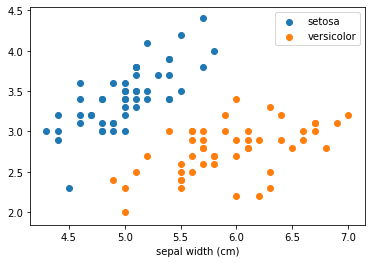

In [5]:
sepal_features = ['sepal length (cm)','sepal width (cm)']
setosa = iris_df[iris_df.label == 0][sepal_features]
versicolor = iris_df[iris_df.label == 1][sepal_features]

plt.scatter(setosa.values[:,0], setosa.values[:,1], label='setosa')
plt.scatter(versicolor.values[:,0], versicolor.values[:,1], label='versicolor')
plt.xlabel(sepal_features[0])
plt.xlabel(sepal_features[1])
plt.legend()

## 准备算法模型

In [6]:
class Model():
    def __init__(self):
        self.bias = 0

    def fit(self, X_train, y_train):
        self.X = np.round(X_train).astype(np.int)
        self.y = y_train.astype(np.int)

    def predict(self, X_pred):
        X_pred = np.round(X_pred).astype(np.int)
        M = np.hstack((self.X, self.y.reshape(y_train.shape[0],1)))
        N = len(M)
        K = len(np.unique(y_train))
        J = len(M[0])
        y_pred = []
        for x in X_pred:
            match = None
            score = -1
            for y in np.unique(y_train):
                y_count = len(M[M[:,J-1]==y])
                ans = (y_count + 1) / (N + K)
                for j in range(J-1):
                    x_count = len(M[(M[:,J-1]==y) & (M[:,j]==x[j])])
                    Sj = len(np.unique(M[:,j]))
                    ans *= (x_count + 1) / (y_count + Sj)
                if ans > score:
                    match = y
                    score = ans
            y_pred.append(match)
        return np.array(y_pred)

## 准备训练数据

In [7]:
sepal_features = ['sepal length (cm)','sepal width (cm)']
X_train = iris_df[iris_df.label.isin([0,1])][sepal_features].values
y_train = iris_df[iris_df.label.isin([0,1])]['label'].values

In [8]:
X_pred = np.random.rand(20, 2) * [2.5, 1.5] + [4.5, 2.5]

## 模型预测

In [9]:
model = Model()
model.fit(X_train, y_train)
y_pred = model.predict(X_pred)
y_pred

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1])

## 画图验证

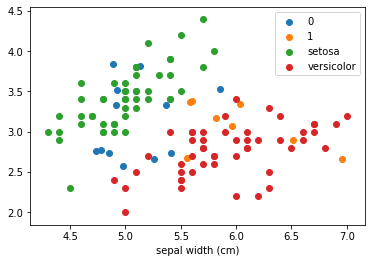

In [10]:
sepal_features = ['sepal length (cm)','sepal width (cm)']
setosa = iris_df[iris_df.label == 0][sepal_features]
versicolor = iris_df[iris_df.label == 1][sepal_features]

plt.scatter(X_pred[y_pred==0][:,0], X_pred[y_pred==0][:,1], label='0')
plt.scatter(X_pred[y_pred==1][:,0], X_pred[y_pred==1][:,1], label='1')

plt.scatter(setosa.values[:,0], setosa.values[:,1], label='setosa')
plt.scatter(versicolor.values[:,0], versicolor.values[:,1], label='versicolor')
plt.xlabel(sepal_features[0])
plt.xlabel(sepal_features[1])
plt.legend()

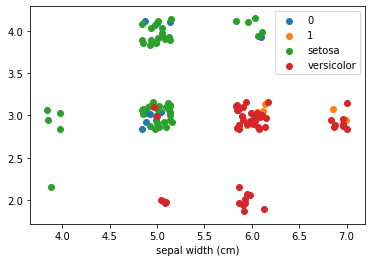

In [11]:
sepal_features = ['sepal length (cm)','sepal width (cm)']
setosa = iris_df[iris_df.label == 0][sepal_features]
versicolor = iris_df[iris_df.label == 1][sepal_features]

plt.scatter(np.round(X_pred[y_pred==0][:,0]) + (np.random.rand(len(X_pred[y_pred==0]))-0.5)/3, np.round(X_pred[y_pred==0][:,1]) + (np.random.rand(len(X_pred[y_pred==0]))-0.5)/3, label='0')
plt.scatter(np.round(X_pred[y_pred==1][:,0]) + (np.random.rand(len(X_pred[y_pred==1]))-0.5)/3, np.round(X_pred[y_pred==1][:,1]) + (np.random.rand(len(X_pred[y_pred==1]))-0.5)/3, label='1')

plt.scatter(np.round(setosa.values[:,0]) + (np.random.rand(len(setosa))-0.5)/3, np.round(setosa.values[:,1]) + (np.random.rand(len(setosa))-0.5)/3, label='setosa')
plt.scatter(np.round(versicolor.values[:,0]) + (np.random.rand(len(versicolor))-0.5)/3, np.round(versicolor.values[:,1]) + (np.random.rand(len(versicolor))-0.5)/3, label='versicolor')
plt.xlabel(sepal_features[0])
plt.xlabel(sepal_features[1])
plt.legend()